# Import


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.io import wavfile
import os
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import FunctionTransformer
set_config(display='diagram')

# Đưa ra câu hỏi cần trả lời

* **Nhận diện giới tính thông qua giọng nói:** cột output là "lable"(Male/Female), input là các đặc trưng cơ bản được rút trích từ giọng nói

* **Lợi ích khi trả lời câu hỏi:** Phục vụ cho quá trình xác định giới tính trong điều tra tội phạm. Là một phần của Voice AI. Ngoài ra nó còn hỗ trợ cho các ngành dịch vụ cần phân tích giới tính khách hàng để mang lại chất lượng phục vụ tốt hơn
* **Nguồn cảm hứng:** dựa vào các ứng dụng xác định giới tính bằng hình ảnh

# Thu thập dữ liệu

* Dữ liệu được thu thập từ trang thu thập dữ liệu [Voxforge](http://www.repository.voxforge1.org/downloads/SpeechCorpus/Trunk/Audio/Main/16kHz_16bit/)
* Do thời gian thu thập dữ liệu rất lâu nên nhóm em không chạy trong file notebook mà toàn bộ quá trình thu thập dữ liệu và vài thao tác tiền xử lí đơn giản được viết bằng các file python trong thư mục *Data*, cụ thể là:
    * *web_scrapping.py* sử dụng thư viện BeautifulSoup parse các link, sau đó tải tất cả các file về thư mục *raw_data*
    * Các file tải về đang bị nén ở định dạng tgz nên *unzip.py* sử dụng thư viện tarfile để giải nén
    * Sau khi giải nén thì mỗi file sẽ gồm 2 thư mục *wav*(chứa các audio) và *etc*(chứa các thông tin của mẫu). Trong thư mục *etc* ta quan tâm đến file README chứa giới tính của mẫu đó. *feature_extraction.py* dùng để rút trích các đặc điểm cơ bản của một file audio và lấy thông tin về giới tính của mẫu. Tham khảo từ [stackoverflow](https://stackoverflow.com/questions/40996620/extracting-frequencies-from-a-wav-file-python)

# Khám phá dữ liệu

## Vẽ các đồ thị của một file wav

Tham khảo từ [Audio signals in python](http://myinspirationinformation.com/uncategorized/audio-signals-in-python/)

In [2]:
wav_file = '../Data/raw_data/chris-20090325-esw/wav/a0060.wav'
rate, data = wavfile.read(wav_file)

In [3]:
ipd.Audio(wav_file)

### Biên độ âm theo thời gian

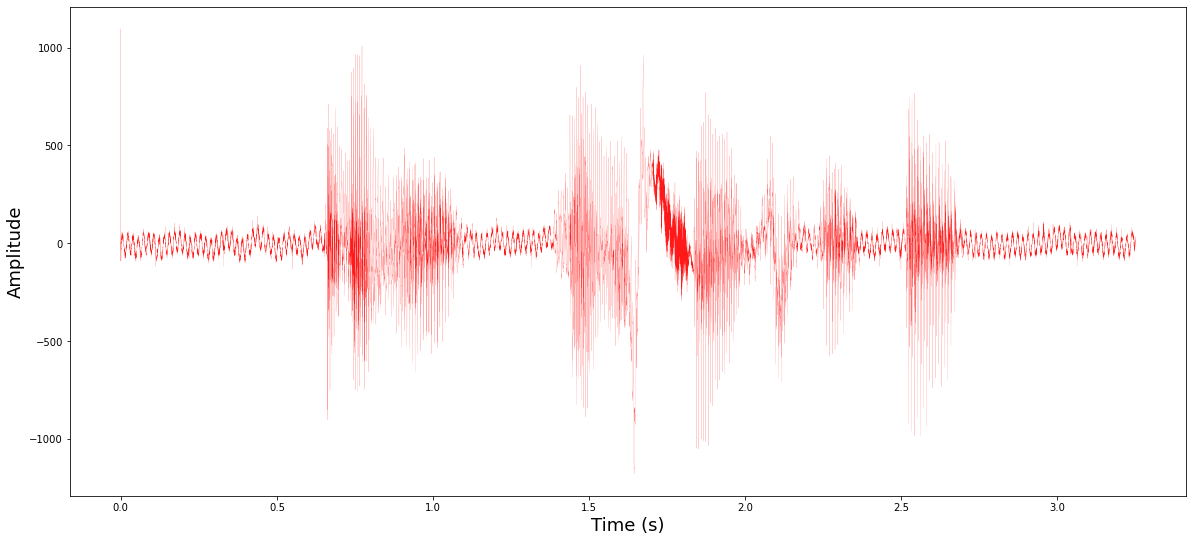

In [4]:
time = np.arange(0, float(data.shape[0]), 1) / rate
plt.figure(1, figsize=(20,9))
plt.subplot(111)
plt.plot(time, data, linewidth=0.1, alpha=0.9, color='#ff0000')
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.show();


### Biên độ âm theo tần số

C:\Users\vu389\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


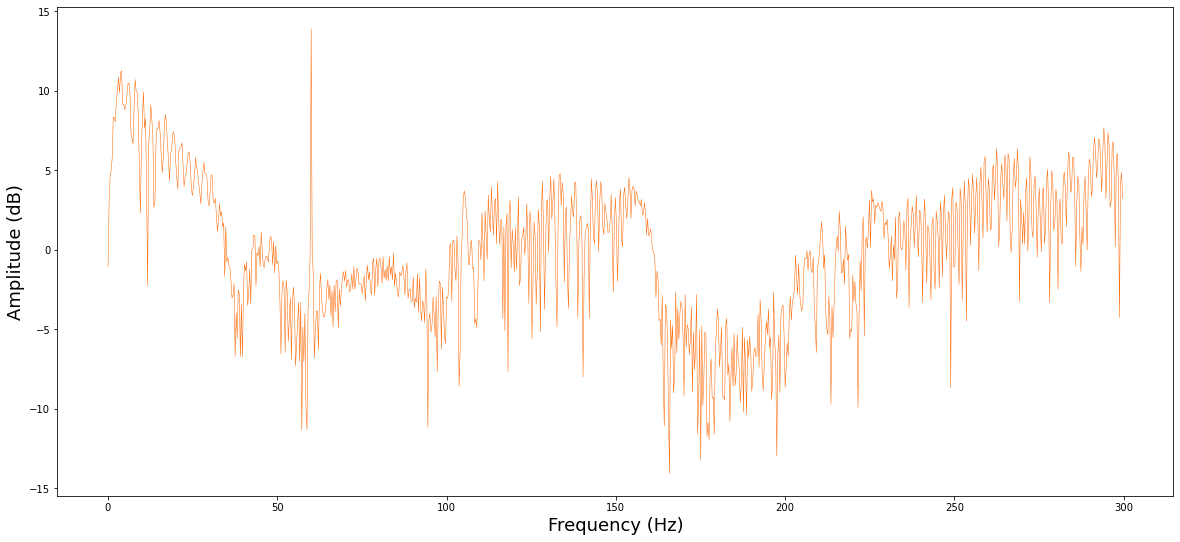

In [5]:
fourier = np.fft.fft(data)

n = len(data)
fourier = fourier[0:int(n/2)]

fourier = fourier / float(n)

freqArray = np.arange(0, (n/2), 1.0) * (rate*1.0/n);
x = freqArray[freqArray<300] #human voice range
y = 10*np.log10(fourier)[0:len(x)]
plt.figure(1,figsize=(20,9))
plt.plot(x, y, color='#ff6600', linewidth=0.5)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.ylabel('Amplitude (dB)', fontsize=18)
plt.show();


### Thời gian theo tần số (Heatmap)

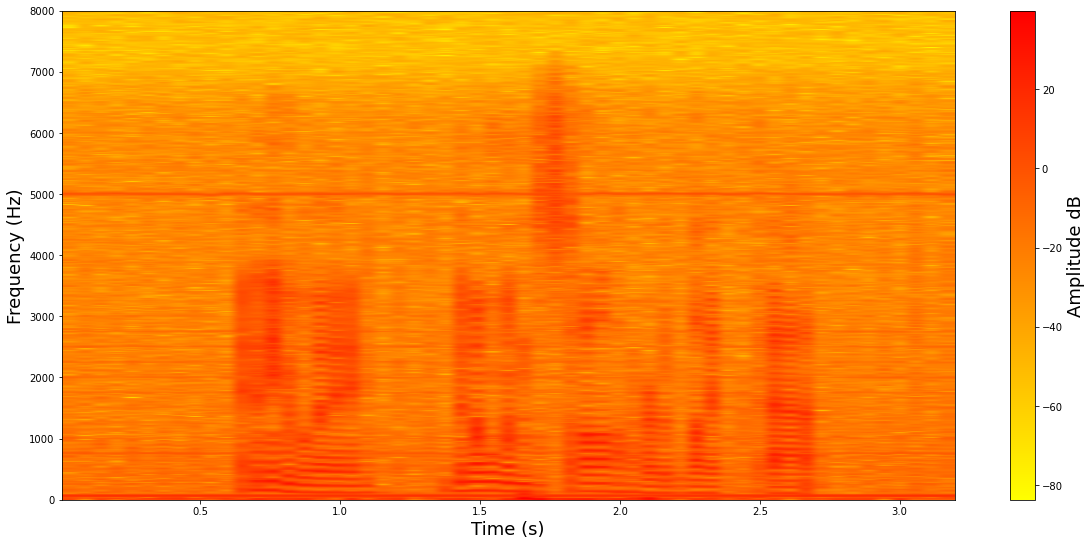

In [6]:
plt.figure(1,figsize=(20,9))
plt.subplot(111)
Pxx, freqs, bins, im = plt.specgram(data, Fs=rate, NFFT=1024, cmap=plt.get_cmap('autumn_r'))
cbar=plt.colorbar(im)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Frequency (Hz)', fontsize=18)
cbar.set_label('Amplitude dB', fontsize=18)
plt.show()

## Đọc dữ liệu

In [7]:
data_df = pd.read_csv('../Data/clean_Data.csv', index_col=0)
data_df.head()

,nobs,mean,skewness,kurtosis,median,mode,std,low,peak,q25,q75,iqr,lable
0,86.0,150.000000,-0.138477,-1.166599,140.0,90.0,68.759777,25.0,285.0,91.25,208.75,117.5,Male
1,106.0,188.962264,-1.220764,0.120848,215.0,220.0,77.419212,25.0,290.0,185.00,235.00,50.0,Female
2,118.0,193.220339,-1.376989,0.729752,212.5,200.0,67.803072,25.0,295.0,190.00,235.00,45.0,Female
3,121.0,159.724518,-0.540255,-1.472180,205.0,30.0,92.830539,25.0,285.0,40.00,230.00,190.0,Unknow
4,34.0,159.558824,-0.893693,-0.636448,185.0,25.0,73.748057,25.0,245.0,122.50,215.00,92.5,Male


## Dữ liệu có bao nhiêu dòng và bao nhiêu cột

In [8]:
data_df.shape

(5209, 13)

## Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Mỗi dòng chứa các đặc trưng của một thư mục chứa các mẫu âm thanh. Không có vấn đề về các dòng có ý nghĩa khác nhau

## Dữ liệu các dòng có bị lặp không

In [9]:
data_df.index.duplicated().sum()

0

## Mỗi cột có ý nghĩa gì

In [10]:
schema_df = pd.read_csv('../Data/schema.csv')
pd.set_option('display.max_colwidth',-1)
schema_df

<ipython-input-10-138cc933f7dd>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


,Columns,Acoustic properties
0,nobs,Number of observations
1,mean,average of frequency measured across acoustic signal
2,skewness,skewness
3,kurtosis,kurtosis
4,median,median frequency(in Hz)
5,mode,mode frequency
6,std,standard deviation of frequency
7,low,frequency with lowest energy
8,peak,frequency with highest energy
9,q25,first quantile(in Hz)


## Dữ liệu có bị thiếu hay không ?

In [11]:
data_df.isna().sum()

nobs        0 
mean        0 
skewness    0 
kurtosis    0 
median      0 
mode        0 
std         0 
low         0 
peak        0 
q25         0 
q75         0 
iqr         0 
lable       17
dtype: int64

Ta thấy chỉ có cột lable chứa giá trị thiếu. Do số lượng dòng có chứa giá trị thiếu rất nhỏ (17 so với 5209) và đồng thời đây cũng là cột output nên ta có thể bỏ qua những dòng output bị thiếu giá trị

In [12]:
# Xóa các dòng bị thiếu dữ liệu
data_df = data_df.dropna()
data_df.shape

(5192, 13)

## Các cột có kiểu dữ liệu gì ?

In [13]:
data_df.dtypes

nobs        float64
mean        float64
skewness    float64
kurtosis    float64
median      float64
mode        float64
std         float64
low         float64
peak        float64
q25         float64
q75         float64
iqr         float64
lable       object 
dtype: object

# Khám phá dữ liệu (để tách các tập)

## Các giá trị của cột output

In [14]:
data_df['lable'].value_counts()

Male      4764
Female    379 
Unknow    49  
Name: lable, dtype: int64

Do các giá trị Unknow là các giá không biết tương tự giá trị thiếu nên ta cũng cần bỏ luôn các giá trị Unknow

In [15]:
# Bỏ các dòng chứa giá trị 'Unknow'
data_df = data_df[data_df['lable'] != 'Unknow']

In [16]:
# Tỉ lệ các lớp trong cột output
data_df['lable'].value_counts(normalize = True) * 100

Male      92.63076
Female    7.36924 
Name: lable, dtype: float64

Dữ liệu ở cột output bị lệch khá nghiêm trọng nên ở bước tiền xử lý ta cần xử lý tình trạng này

## Kiểu dữ liệu của cột output

In [17]:
data_df['lable'].dtype

dtype('O')

Do cột output có dữ liệu là Object nên ta cần chuyển về kiểu dữ liệu số (dữ liệu dạng Sklearn)

In [18]:
data_df['lable'] = np.where(data_df['lable'] == 'Male', 1, 0)

In [19]:
# Tỉ lệ các lớp trong cột output
data_df['lable'].value_counts(normalize = True) * 100

1    92.63076
0    7.36924 
Name: lable, dtype: float64

# Tiền xử lý (tách các tập)

Do kết quả của mô hình là xác định giới tính nam, nữ vì vậy tập test set của chúng ta cần chứa giá trị nam nữ với tỉ lệ bằng nhau (Bởi vì không có lý do gì đặc biệt như "xét ung thư hay không" nên bắt buộc ta phải để tỉ lệ nam nữ bằng nhau)

In [20]:
female = data_df[data_df['lable'] == 0]
male = data_df[data_df['lable'] == 1]
len(female), len(male)

(379, 4764)

In [21]:
train_female, test_female = train_test_split(female, test_size = 0.2,
                                            random_state = 0)
len(train_female), len(test_female)

(303, 76)

Do tập tỉ lệ male_female trong test phải băng nhau nên ta cần set tham số test_size = 76/4764 để có thể lấy được tập test_male = 76

In [22]:
train_male, test_male = train_test_split(male, test_size = 76/4764,
                                        random_state = 0)
len(train_male), len(test_male)

(4688, 76)

In [46]:
train = pd.concat([train_male, train_female])
test = pd.concat([test_male, test_female])

train['lable'].value_counts(), test['lable'].value_counts()

(1    4688
 0    303 
 Name: lable, dtype: int64,
 1    76
 0    76
 Name: lable, dtype: int64)

In [24]:
# Tách X và y
train_val_y_sr = train['lable']
train_val_X_df = train.drop('lable', axis = 1)

test_y_sr = test['lable']
test_X_df = test.drop('lable', axis = 1)

In [25]:
# Tách tập train set và validation set theo tỉ lệ 80%:20%
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(train_val_X_df, train_val_y_sr, test_size=0.2, 
                                                              stratify=train_val_y_sr, random_state=0)

In [26]:
train_X_df.shape

(3992, 12)

In [27]:
train_y_sr.shape

(3992,)

In [28]:
val_X_df.shape

(999, 12)

In [29]:
val_y_sr.shape

(999,)

In [30]:
test_X_df.shape

(152, 12)

In [31]:
test_y_sr.shape

(152,)

## Khám phá dữ liệu (tập huấn luyện)

Sau khi đã tách ra các tập thì ta có thể thoải mái khám phá trên tập huấn luyện mà không lo sẽ làm kết quả trên tập validation và tập kiểm tra bị mất đi sự khách quan.

### Mỗi cột input hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [32]:
train_X_df.dtypes

nobs        float64
mean        float64
skewness    float64
kurtosis    float64
median      float64
mode        float64
std         float64
low         float64
peak        float64
q25         float64
q75         float64
iqr         float64
dtype: object

Tất cả các cột dữ liệu trong input đều là dạng số

### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

In [33]:
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
train_X_df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max']).round(1)

,nobs,mean,skewness,kurtosis,median,mode,std,low,peak,q25,q75,iqr
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,11.0,28.9,-19.0,-1.9,25.0,25.0,0.0,20.0,44.1,25.0,30.0,0.0
lower_quartile,59.0,120.9,-0.3,-0.9,112.5,95.0,38.6,25.0,265.0,90.0,133.8,25.0
median,100.0,147.6,0.4,0.1,130.0,120.0,51.9,34.7,290.0,115.0,185.0,55.0
upper_quartile,155.0,183.1,1.0,2.3,190.0,180.0,64.8,85.0,295.0,135.0,233.8,98.8
max,7328.0,276.1,14.9,358.0,287.5,295.0,118.6,245.0,299.9,278.8,295.0,252.5


# Tiền xử lý (tập huấn luyện)

## Tiền xử lý input

Do tất cả các cột dữ liệu input đầu vào đều là dạng số nên ta cần điền giá trị thiếu cho các côt dạng số bằng giá trị mean của cột. Với tất cả các cột dạng số trong tập huấn luyện, ta đều cần tính mean, vì ta không biết được cột nào sẽ bị thiếu giá trị khi dự đoán với các véc-tơ input mới.

Sau đó ta sẽ tiến hành chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn

In [34]:
preprocess_pipeline = make_pipeline(SimpleImputer(missing_values = np.nan),
                                   StandardScaler())
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)

## Tiền xử lý output

Ở trên ta thấy dữ liệu output bị lệch nghiệm trọng nên ta cần cân bằng lại để tăng độ chính xác cho mô hình. Do đó em sẽ thử nghiệm các phương pháp lấy lại mẫu là Oversampling và Undersampling. Tham khảo từ [Towards DataScience](https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36)

### Tăng số mẫu (Oversamples)

In [35]:
def upsamples_features(X, y):
    # Lấy tập dữ liệu train
    train_data = pd.concat([X, y], axis = 1)
    # Tách tập male và female
    male = train_data[train_data['lable'] == 1]
    female = train_data[train_data['lable'] != 1]
    # Tăng số lượng mẫu ít giá trị (female)
    female_upsampled = resample(female, replace = True,
                                n_samples = len(male), random_state = 0)
    
    upsampled_train_data = pd.concat([male, female_upsampled])
    # Tách input và output
    upsampled_train_y_sr = upsampled_train_data['lable']
    upsampled_train_X_df= upsampled_train_data.drop('lable', axis = 1)
    
    return upsampled_train_X_df, upsampled_train_y_sr


In [36]:
upsampled_train_X_df, upsampled_train_y_sr = upsamples_features(train_X_df, train_y_sr)
train_y_sr.value_counts(), upsampled_train_y_sr.value_counts()

(1    3750
 0    242 
 Name: lable, dtype: int64,
 1    3750
 0    3750
 Name: lable, dtype: int64)

### Giảm số mẫu (Undersamples)

In [37]:
def downsamples_features(X, y):
    # Lấy tập dữ liệu train
    train_data = pd.concat([X, y], axis = 1)
    # Tách tập male và female
    male = train_data[train_data['lable'] == 1]
    female = train_data[train_data['lable'] != 1]
    # Giảm số lượng mẫu nhiều giá trị (male)
    male_downsampled = resample(male, replace = True,
                                n_samples = len(female), random_state = 0)

    downsampled_train_data = pd.concat([male_downsampled, female])
    # Tách input và output
    downsampled_train_y_sr = downsampled_train_data['lable']
    downsampled_train_X_df= downsampled_train_data.drop('lable', axis = 1)
    
    return downsampled_train_X_df, downsampled_train_y_sr

In [38]:
downsampled_train_X_df, downsampled_train_y_sr = downsamples_features(train_X_df, train_y_sr)
train_y_sr.value_counts(), downsampled_train_y_sr.value_counts()

(1    3750
 0    242 
 Name: lable, dtype: int64,
 1    242
 0    242
 Name: lable, dtype: int64)

# Tiền xử lý + Mô hình hóa

## Tìm mô hình tốt nhất

In [39]:
# FULL pipeline
full_pipeline = make_pipeline(SimpleImputer(missing_values = np.nan),
                              StandardScaler(),
                              MLPClassifier(hidden_layer_sizes=(20), activation='tanh',
                                            solver='lbfgs', random_state=0, max_iter=2500))

### Sử dụng data đã được tăng số mẫu

In [40]:
# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.1, 1, 10, 100, 1000]
up_best_val_err = float('inf'); up_best_alpha = None
for alpha in alphas:
    full_pipeline.set_params(mlpclassifier__alpha=alpha)
        
    # Huấn luyện trên tập huấn luyện
    full_pipeline.fit(upsampled_train_X_df, upsampled_train_y_sr)
    # Độ lỗi trên tập huấn luyện
    train_predict = full_pipeline.predict(upsampled_train_X_df)
    train_error = ((upsampled_train_y_sr - train_predict)**2).mean() * 100
    train_errs.append(train_error)
    # Độ lỗi trên tập validation
    val_predict = full_pipeline.predict(val_X_df)
    val_error = ((val_y_sr - val_predict)**2).mean() * 100
        
    if (len(val_errs) == 0) or (val_error < min(val_errs)):
        up_best_val_err = val_error
        up_best_alpha = alpha
            
    val_errs.append(val_error)

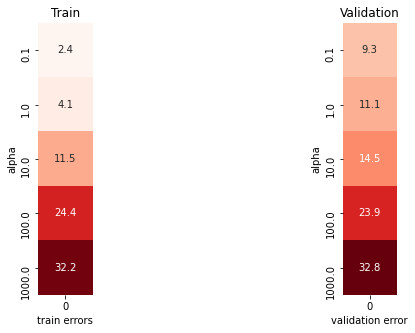

In [41]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Train'); plt.xlabel('train errors'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Validation'); plt.xlabel('validation error'); plt.ylabel('alpha');

### Sử dụng data đã được giảm số mẫu

In [42]:
# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.1, 1, 10, 100, 1000]
down_best_val_err = float('inf'); down_best_alpha = None
for alpha in alphas:
    full_pipeline.set_params(mlpclassifier__alpha=alpha)
        
    # Huấn luyện trên tập huấn luyện
    full_pipeline.fit(downsampled_train_X_df, downsampled_train_y_sr)
    # Độ lỗi trên tập huấn luyện
    train_predict = full_pipeline.predict(downsampled_train_X_df)
    train_error = ((downsampled_train_y_sr - train_predict)**2).mean() * 100
    train_errs.append(train_error)
    # Độ lỗi trên tập validation
    val_predict = full_pipeline.predict(val_X_df)
    val_error = ((val_y_sr - val_predict)**2).mean() * 100
        
    if (len(val_errs) == 0) or (val_error < min(val_errs)):
        down_best_val_err = val_error
        down_best_alpha = alpha
            
    val_errs.append(val_error)

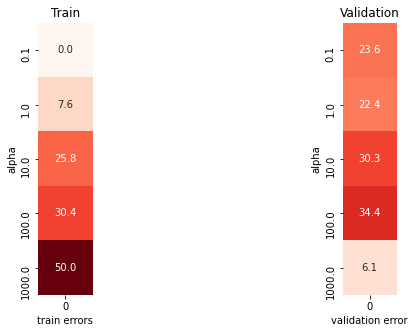

In [43]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Train'); plt.xlabel('train errors'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Validation'); plt.xlabel('validation error'); plt.ylabel('alpha');

### Nhận xét các phương pháp resampling

Có thể thấy phương pháp undersampling trong trường hợp tốt nhất cho tỉ tệ lỗi nhỏ nhất (7.4%) tuy nhiên đây là do phương pháp này đã phân lớp 100% là nam. Do đó độ lỗi này là không đáng tin cậy. Vậy nên giữa hai phương pháp là undersampling và oversampling thì nhóm em sẽ chọn phương pháp oversampling để đánh giá tập test.

## Đánh giá mô hình

In [44]:
full_pipeline.set_params(mlpclassifier__alpha=up_best_alpha)
up_train_val_X_df, up_train_val_y_sr = upsamples_features(train_val_X_df, train_val_y_sr)

full_pipeline.fit(up_train_val_X_df, up_train_val_y_sr)

result = full_pipeline.predict(test_X_df)

error = ((test_y_sr - result)**2).mean() * 100
print(error)

26.31578947368421


# Nhìn lại quá trình làm đồ án của nhóm

## Những khó khăn đã gặp

- Quá trình chọn đề tài của nhóm mất rất nhiều thời gian. Nhóm em đã bắt đầu suy nghĩ và liệt kê ra những đề tài từ những buổi học thu thập dữ liệu đầu tiên và thử thu thập dữ liệu cho đề các đề tài đó. Tuy nhiên gặp phải rất nhiều khó khăn như là: chọn phải những đề tài mơ hồ, không rõ ràng; có đề tài hay nhưng lại khó thu thập được dữ liệu chính xác hoặc các api không hỗ trợ miễn phí; có đề tài hợp lí và có được nguồn dữ liệu nhưng ý nghĩa mang lại không cao.
- Cuối cùng thì em tìm được nguồn dữ liệu và đề tài tương đối hợp lí nhưng dữ liệu bị lệch khá nghiêm trọng. Điều này cũng dẫn đến chút khó khăn trong quá trình xây dựng mô hình.
- Điều em cảm thấy khó khăn nhất khi thực hiện đồ án này là tìm hiểu về các đặc trưng của âm thanh và rút trích ra các đặc trưng đó. Em có tham khảo dữ liệu có sẵn của google (ở dạng csv chứ không phải file audio), em thấy có khoảng 30 thuộc tính. Em đã tìm hiểu khá nhiều nhưng chỉ rút trích được 14 thuộc tính từ dữ liệu đang có và có nhiều thuộc tính em vẫn chưa hiểu hết về nó.

## Những điều học được thông qua đồ án

Qua đồ án này em đã học được rất nhiều thứ:
- Cần có sự phân bố thời gian hơp lí hơn. Do nhóm bắt đầu tìm kiếm đề tài khá sớm nhưng lại không quyết định được đề tài mình sẽ làm để bắt đầu thực hiện bước tiếp theo của đồ án.
- Có hiểu biết cơ bản về xử lí dữ liệu audio
- Học được cách trình bày, làm việc nhóm nghiêm túc, trách nhiệm hơn.
- Hiểu rõ hơn về quy trình của một dự án khoa học dữ liệu
- Học thêm được các phương pháp xử lí tập dữ liệu bị lệch
- Học được cách đánh giá mô hình hợp lí(Không để con số độ lỗi thấp làm mờ mắt mà không kiểm tra lại các giá trị dự đoán): các mô hình tốt nhất ban đầu đề có độ lỗi là 7.4% nhưng nhóm đã dùng confusion matrix để  xem lại và thấy mô hình đó đang dự đoán 100% là nam. Và trên tập validation bị lệch nên mới có độ lỗi tốt như vậy.
- Điều quý giá nhất em học được từ đồ án này là việc cần có ý thức tham gia đóng góp dữ liệu ở các trang thu thập dữ liệu và cho phép sử dụng chúng miễn phí hay tham gia các cuộc khảo sát có ý nghĩa để giúp đỡ những dự án có hữu ích đối với cộng đồng.

## Nếu có thêm thời gian thì nhóm sẽ làm gì?

Nếu có thêm thời gian nhóm sẽ tìm nguồn dữ liệu phù hợp hơn (không bị lệch) để mô hình tốt hơn, thử thêm nhiều mô hình học máy khác. Tìm kiếm thêm các phương pháp khác để giúp cho độ lỗi của mô hình giảm thêm. Và điều em muốn bổ sung vào đồ án này đó là viết một api đơn giản để có thể test mô hình bằng giọng nói ngay trong đồ án này 